# Noise 빼고 rho 추가

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
from Grouping import *
tf.disable_eager_execution()

# RL (DQN)

In [2]:
def RL_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param, Algorithm):
    def make_list(n, v=0):
        if v:
            l = [[0]*v]
            for _ in range(n-1):
                l += [[0]*v]
        else:
            l = [[]]
            for _ in range(n-1):
                l += [[]]
        return l

    def bit(VN, N, l):
        new_l = make_list(len(l))
        for i in range(len(l)):
            l[i] = list(map(int, l[i]))
            zeros = np.zeros(VN)
            zeros[l[i]] = 1
            new_l[i] = zeros
        return np.array(new_l)

    def zipf(VN, N, P, n, a=1):
        if len(P.shape) == 1:
            P = np.array([P])
        C = make_list(N)
        for i in range(N):
            C[i] = np.random.choice([i for i in range(VN)], n, False, P[i])
        return np.array(C)

    class cache_env:
        def __init__(self, VN, N, cs, a=1):
            self.VN = VN
            self.N = N
            self.cs = cs
            self.a = a
            self.P = np.array([np.array([1/(i**self.a) for i in range(1, self.VN+1)]) for _ in range(self.N)])
            self.P /= np.array([np.sum(self.P, 1)]).transpose()
            for i in range(self.N):
                np.random.shuffle(self.P[i])
            self.state = make_list(self.N)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            self.rq_count = np.array(make_list(self.N, self.VN))

        def step(self, replace, Algorithm = 'FIFO'):
            prev_state = np.hstack((bit(self.VN, self.N, self.request),bit(self.VN, self.N, self.state)))
            count = 0
            # self.rq_count = self.rq_count * 0.9  # LFU의 단점 개선
            for i in range(self.N):
                if replace[i]:
                    if Algorithm == 'FIFO':
                        self.FIFO(i)
                    elif Algorithm == 'LFU':
                        self.LFU(i)
                    elif Algorithm == 'LRU':
                        self.LRU(i)
                    else:
                        raise NameError('Wrong Algorithm Name')
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            cn, rq, ch = Local(self.request, self.state)
            cn, rq, ch = BCG(list(range(self.VN)), cn, rq, ch)
            cn, rq, ch = XBCG(list(range(self.VN)), cn, rq, ch)
            connection = len(cn)
            reward = np.ones((self.N, 1)) * (self.N / 2 - connection) / self.N
            for i in range(self.N):
                while self.request[i][0] in self.state[i]:
                    if Algorithm == 'LRU':
                        self.LRU(i)
                    self.request[i] = zipf(self.VN, 1, self.P[i], 1, self.a)[0]
                    self.rq_count[i][self.request[i][0]] += 1
                    count += 1
            return prev_state, count, reward, connection

        def FIFO(self, idx):
            if self.request[idx][0] not in self.state[idx]:
                if len(self.state[idx]) < self.cs:
                    self.state[idx] = list(np.hstack((self.state[idx], self.request[idx])))
                else:
                    self.state[idx] = list(np.hstack((self.state[idx][1:], self.request[idx])))

        def LFU(self, idx):
            if self.request[idx][0] not in self.state[idx]:
                if len(self.state[idx]) < self.cs:
                    self.state[idx].append(self.request[idx][0])
                else:
                    count_l = self.rq_count[idx][np.array(self.state[idx])]
                    min_idx = np.where(np.array(count_l) == min(count_l))[0]
                    self.state[idx].remove(self.state[idx][min_idx[0]])
                    self.state[idx].append(self.request[idx][0])
                    
        def LRU(self, idx):
            if self.request[idx] in self.state[idx]:
                self.state[idx] = np.delete(self.state[idx], np.where(self.state[idx] == self.request[idx][0])[0])
                self.state[idx] = np.hstack((self.state[idx], self.request[idx]))
            else:
                if len(self.state[idx]) < self.cs:
                    self.state[idx] = list(np.hstack((self.state[idx], self.request[idx])))
                else:
                    self.state[idx] = list(np.hstack((self.state[idx][1:], self.request[idx])))
    
    RL_connection = np.zeros(N)
    RL_test = np.zeros(test_N)
    action_state = 2
    learning_rate = 0.1
    dis = 0.9

    memory_size = 50
    state_memory = []
    reward_memory = []
    batch_size = 10
    
    X = tf.placeholder(shape=[num_of_client, num_of_video * 2], dtype = tf.float32)
    W = tf.Variable(tf.random_uniform([num_of_video * 2, action_state], 0, 0.01))

    Qpred = tf.matmul(X, W)
    Y = tf.placeholder(shape=[num_of_client, action_state], dtype = tf.float32)
    loss = tf.reduce_sum(tf.square(Y - Qpred))

    train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        for m in range(M):
            sess.run(init)
            cache = cache_env(num_of_video, num_of_client, cache_size, zipf_param)
            train_r = 0
            train_count = 0
            train_hit = []
            for i in range(N):
                e = 1/(i/10+1)
                Qs = sess.run(Qpred,feed_dict={X:np.hstack((bit(cache.VN,cache.N,cache.request),bit(cache.VN,cache.N,cache.state)))})

                if np.random.rand(1) < e:
                    a = np.random.randint(2, size = (num_of_client))
                else:
                    a = np.argmax(Qs, 1)
                
                if (i+1) % ch_interval == 0:
                    new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
                    new_P /= np.array([np.sum(new_P, 1)]).transpose()
                    for k in range(cache.N):
                        np.random.shuffle(new_P[k])
                    cache.P = rho * cache.P + (1-rho) * new_P
                
                prev_state, count, reward, connection = cache.step(a, Algorithm)
                state = np.hstack((bit(cache.VN, cache.N, cache.request),bit(cache.VN, cache.N, cache.state)))
                reward = reward * np.identity(action_state)[a]
                
                if len(state_memory) >= memory_size:
                    state_memory = state_memory[1:]
                    reward_memory = reward_memory[1:]
                state_memory.append(np.array([prev_state, state]))
                reward_memory.append(reward)
                
                random_idx = np.random.choice(list(range(len(state_memory))), min(batch_size, len(state_memory)), False)
                state_batch = sum(np.array([state_memory[k] for k in random_idx])) / len(random_idx)
                reward_batch = sum([reward_memory[k] for k in random_idx]) / len(random_idx)
                
                Qs1 = sess.run(Qpred, feed_dict = {X:state_batch[1]})
                maxQ = np.array([np.max(Qs1, 1)]).transpose()
                Qs = reward_batch + dis * np.hstack((maxQ,maxQ)) * np.identity(action_state)[np.argmax(Qs1, 1)]
                sess.run(train, feed_dict = {X:state_batch[0], Y:Qs})

                train_r += connection
                train_count += count + num_of_client
                train_hit.append(train_r / train_count)
            RL_connection += np.array(train_hit)
    
            test_r = 0
            test_count = 0
            test_hit = []
            for i in range(test_N):                
                Qs = sess.run(Qpred,feed_dict={X:np.hstack((bit(cache.VN,cache.N,cache.request),bit(cache.VN,cache.N,cache.state)))})
                a = np.argmax(Qs, 1)
                
                if (i+1) % ch_interval == 0:
                    new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
                    new_P /= np.array([np.sum(new_P, 1)]).transpose()
                    for k in range(cache.N):
                        np.random.shuffle(new_P[k])
                    cache.P = rho * cache.P + (1-rho) * new_P
                    
                _, count, _, connection = cache.step(a, Algorithm)
                
                test_r += connection
                test_count += count + num_of_client
                test_hit.append(test_r / test_count)
            RL_test += np.array(test_hit)
            
    return RL_connection/M, RL_test/M

# FIFO

In [3]:
def FIFO_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param):
    def make_list(n):
        l = [[]]
        for _ in range(n-1):
            l += [[]]
        return l

    def zipf(VN, N, P, n, a=1):
        if len(P.shape) == 1:
            P = np.array([P])
        C = make_list(N)
        for i in range(N):
            C[i] = list(np.random.choice([i for i in range(VN)], n, False, P[i]))
        return C

    class cache_env:
        def __init__(self, VN, N, cs, a=1):
            self.VN = VN
            self.N = N
            self.cs = cs
            self.a = a
            self.P = np.array([[1/(i**self.a) for i in range(1, self.VN+1)] for _ in range(self.N)])
            self.P /= np.array([np.sum(self.P, 1)]).transpose()
            for i in range(self.N):
                np.random.shuffle(self.P[i])
            self.state = make_list(N)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)

        def step(self):
            count = 0
            self.replacement()
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            cn, rq, ch = Local(self.request, self.state)
            cn, rq, ch = BCG(list(range(self.VN)), cn, rq, ch)
            connection = len(cn)
            cn, rq, ch = XBCG(list(range(self.VN)), cn, rq, ch)
            Xconnection = len(cn)
            for i in range(self.N):
                while self.request[i][0] in self.state[i]:
                    self.request[i] = zipf(self.VN, 1, self.P[i], 1, self.a)[0]
                    count += 1
            return count, connection, Xconnection

        def replacement(self):
            for i in range(self.N):
                if self.request[i][0] not in self.state[i]:
                    if len(self.state[i]) < self.cs:
                        self.state[i].append(self.request[i][0])
                    else:
                        self.state[i] = self.state[i][1:] + self.request[i]
            
    FIFO_connection = np.zeros(N)
    FIFO_Xconnection = np.zeros(N)
    FIFO_test = np.zeros(test_N)
    FIFO_Xtest = np.zeros(test_N)
    for m in range(M):
        cache = cache_env(num_of_video, num_of_client, cache_size, zipf_param)
        FIFO_r = 0
        FIFO_Xr = 0
        FIFO_count = 0
        FIFO_hit = []
        FIFO_Xhit = []
        for i in range(N):
            if (i+1) % ch_interval == 0:
                new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
                new_P /= np.array([np.sum(new_P, 1)]).transpose()
                for k in range(cache.N):
                    np.random.shuffle(new_P[k])
                cache.P = rho * cache.P + (1-rho) * new_P
            
            count, connection, Xconnection = cache.step()
            FIFO_r += connection
            FIFO_Xr += Xconnection
            FIFO_count += count + num_of_client
            FIFO_hit.append(FIFO_r / FIFO_count)
            FIFO_Xhit.append(FIFO_Xr / FIFO_count)
        FIFO_connection += np.array(FIFO_hit)
        FIFO_Xconnection += np.array(FIFO_Xhit)

        test_r = 0
        test_Xr = 0
        test_count = 0
        test_hit = []
        test_Xhit = []
        for i in range(test_N):   
            if (i+1) % ch_interval == 0:
                new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
                new_P /= np.array([np.sum(new_P, 1)]).transpose()
                for k in range(cache.N):
                    np.random.shuffle(new_P[k])
                cache.P = rho * cache.P + (1-rho) * new_P
                
            count, connection, Xconnection = cache.step()
            test_r += connection
            test_Xr += Xconnection
            test_count += count + num_of_client
            test_hit.append(test_r / test_count)
            test_Xhit.append(test_Xr / test_count)
        FIFO_test += np.array(test_hit)
        FIFO_Xtest += np.array(test_Xhit)
    return FIFO_connection/M, FIFO_Xconnection/M, FIFO_test/M, FIFO_Xtest/M

# LFU (각 Client 고유 Frequency)

In [4]:
def LFU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param):
    def make_list(n, v=0):
        if v:
            l = [[0]*v]
            for _ in range(n-1):
                l += [[0]*v]
        else:
            l = [[]]
            for _ in range(n-1):
                l += [[]]
        return l

    def zipf(VN, N, P, n, a=1):
        if len(P.shape) == 1:
            P = np.array([P])
        C = make_list(N)
        for i in range(N):
            C[i] = list(np.random.choice([i for i in range(VN)], n, False, P[i]))
        return C
    
    class cache_env:
        def __init__(self, VN, N, cs, a=1):
            self.VN = VN
            self.N = N
            self.cs = cs
            self.a = a
            self.P = np.array([np.array([1/(i**self.a) for i in range(1, self.VN+1)]) for _ in range(self.N)])
            self.P /= np.array([np.sum(self.P, 1)]).transpose()
            for i in range(self.N):
                np.random.shuffle(self.P[i])
            self.state = make_list(N)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            self.rq_count = np.array(make_list(self.N, self.VN))

        def step(self):
            count = 0
            # self.rq_count = self.rq_count * 0.9  # LFU의 단점 개선
            self.replacement()
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            cn, rq, ch = Local(self.request, self.state)
            cn, rq, ch = BCG(list(range(self.VN)), cn, rq, ch)
            connection = len(cn)
            cn, rq, ch = XBCG(list(range(self.VN)), cn, rq, ch)
            Xconnection = len(cn)
            for i in range(self.N):
                self.rq_count[i][self.request[i][0]] += 1
                while self.request[i][0] in self.state[i]:
                    self.request[i] = zipf(self.VN, 1, self.P[i], 1, self.a)[0]
                    self.rq_count[i][self.request[i][0]] += 1
                    count += 1
            return count, connection, Xconnection

        def replacement(self):
            for i in range(self.N):
                if self.request[i][0] not in self.state[i]:
                    if len(self.state[i]) < self.cs:
                        self.state[i].append(self.request[i][0])
                    else:
                        count_l = self.rq_count[i][np.array(self.state[i])]
                        idx = np.where(np.array(count_l) == min(count_l))[0]
                        self.state[i].remove(self.state[i][idx[0]])
                        self.state[i].append(self.request[i][0])
            
    LFU_connection = np.zeros(N)
    LFU_Xconnection = np.zeros(N)
    LFU_test = np.zeros(test_N)
    LFU_Xtest = np.zeros(test_N)
    for m in range(M):
        cache = cache_env(num_of_video, num_of_client, cache_size, zipf_param)
        LFU_r = 0
        LFU_Xr = 0
        LFU_count = 0
        LFU_hit = []
        LFU_Xhit = []
        for i in range(N):
            if (i+1) % ch_interval == 0:
                new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
                new_P /= np.array([np.sum(new_P, 1)]).transpose()
                for k in range(cache.N):
                    np.random.shuffle(new_P[k])
                cache.P = rho * cache.P + (1-rho) * new_P
            count, connection, Xconnection = cache.step()
            LFU_r += connection
            LFU_Xr += Xconnection
            LFU_count += count + num_of_client
            LFU_hit.append(LFU_r / LFU_count)
            LFU_Xhit.append(LFU_Xr / LFU_count)
        LFU_connection += np.array(LFU_hit)
        LFU_Xconnection += np.array(LFU_Xhit)

        test_r = 0
        test_Xr = 0
        test_count = 0
        test_hit = []
        test_Xhit = []
        for i in range(test_N):            
            if (i+1) % ch_interval == 0:
                new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
                new_P /= np.array([np.sum(new_P, 1)]).transpose()
                for k in range(cache.N):
                    np.random.shuffle(new_P[k])
                cache.P = rho * cache.P + (1-rho) * new_P
                
            count, connection, Xconnection = cache.step()
            test_r += connection
            test_Xr += Xconnection
            test_count += count + num_of_client
            test_hit.append(test_r / test_count)
            test_Xhit.append(test_Xr / test_count)
        LFU_test += np.array(test_hit)
        LFU_Xtest += np.array(test_Xhit)
    return LFU_connection/M, LFU_Xconnection/M, LFU_test/M, LFU_Xtest/M

# LRU

In [5]:
def LRU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param):
    def make_list(n):
        l = [[]]
        for _ in range(n-1):
            l += [[]]
        return l

    def zipf(VN, N, P, n, a=1):
        if len(P.shape) == 1:
            P = np.array([P])
        C = make_list(N)
        for i in range(N):
            C[i] = list(np.random.choice([i for i in range(VN)], n, False, P[i]))
        return C
    
    class cache_env:
        def __init__(self, VN, N, cs, a=1):
            self.VN = VN
            self.N = N
            self.cs = cs
            self.a = a
            self.P = np.array([np.array([1/(i**self.a) for i in range(1, self.VN+1)]) for _ in range(self.N)])
            self.P /= np.array([np.sum(self.P, 1)]).transpose()
            for i in range(self.N):
                np.random.shuffle(self.P[i])
            self.state = make_list(N)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)

        def step(self):
            count = 0
            for i in range(self.N):
                self.replacement(i)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            cn, rq, ch = Local(self.request, self.state)
            cn, rq, ch = BCG(list(range(self.VN)), cn, rq, ch)
            connection = len(cn)
            cn, rq, ch = XBCG(list(range(self.VN)), cn, rq, ch)
            Xconnection = len(cn)
            for i in range(self.N):
                while self.request[i][0] in self.state[i]:
                    self.replacement(i)
                    self.request[i] = zipf(self.VN, 1, self.P[i], 1, self.a)[0]
                    count += 1
            return count, connection, Xconnection

        def replacement(self, idx):
            if self.request[idx][0] in self.state[idx]:
                self.state[idx].remove(self.request[idx][0])
                self.state[idx].append(self.request[idx][0])
            else:
                if len(self.state[idx]) < self.cs:
                    self.state[idx].append(self.request[idx][0])
                else:
                    self.state[idx] = self.state[idx][1:] + self.request[idx]

    LRU_connection = np.zeros(N)
    LRU_Xconnection = np.zeros(N)
    LRU_test = np.zeros(test_N)
    LRU_Xtest = np.zeros(test_N)
    for m in range(M):
        cache = cache_env(num_of_video, num_of_client, cache_size, zipf_param)
        LRU_r = 0
        LRU_Xr = 0
        LRU_count = 0
        LRU_hit = []
        LRU_Xhit = []
        for i in range(N):
            if (i+1) % ch_interval == 0:
                new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
                new_P /= np.array([np.sum(new_P, 1)]).transpose()
                for k in range(cache.N):
                    np.random.shuffle(new_P[k])
                cache.P = rho * cache.P + (1-rho) * new_P
            count, connection, Xconnection = cache.step()
            LRU_r += connection
            LRU_Xr += Xconnection
            LRU_count += count + num_of_client
            LRU_hit.append(LRU_r / LRU_count)
            LRU_Xhit.append(LRU_Xr / LRU_count)
        LRU_connection += np.array(LRU_hit)
        LRU_Xconnection += np.array(LRU_Xhit)

        test_r = 0
        test_Xr = 0
        test_count = 0
        test_hit = []
        test_Xhit = []
        for i in range(test_N):            
            if (i+1) % ch_interval == 0:
                new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
                new_P /= np.array([np.sum(new_P, 1)]).transpose()
                for k in range(cache.N):
                    np.random.shuffle(new_P[k])
                cache.P = rho * cache.P + (1-rho) * new_P
                
            count, connection, Xconnection = cache.step()
            test_r += connection
            test_Xr += Xconnection
            test_count += count + num_of_client
            test_hit.append(test_r / test_count)
            test_Xhit.append(test_Xr / test_count)
        LRU_test += np.array(test_hit)
        LRU_Xtest += np.array(test_Xhit)
    return LRU_connection/M, LRU_Xconnection/M, LRU_test/M, LRU_Xtest/M

# Comparison

In [6]:
M = 1
N = 19500
test_N = 500
num_of_video = 100
num_of_client = 20
cache_size = 10
zipf_param = 1.2
ch_interval = 1000
rho = 0.5

LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


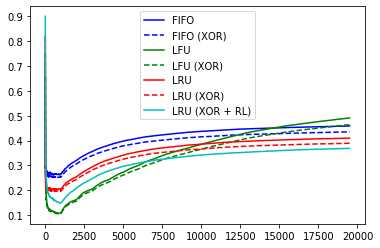

0.4584888648614043
0.4348243612611347
0.4909657050795784
0.46411026102285124
0.40965465437772564
0.3891287471685079
0.3681918765350042


In [7]:
M = 1
N = 19500
test_N = 500
num_of_video = 100
num_of_client = 20
cache_size = 10
zipf_param = 1.2
ch_interval = 1000
rho = 0.5

RL_connection, RL_test = RL_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param, 'LRU')
FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)

t = [n for n in range(N)]

plt.plot(t,FIFO_connection,'b')
plt.plot(t,FIFO_Xconnection,'b--')
plt.plot(t,LFU_connection,'g')
plt.plot(t,LFU_Xconnection,'g--')
plt.plot(t,LRU_connection,'r')
plt.plot(t,LRU_Xconnection,'r--')
plt.plot(t,RL_connection,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

print(FIFO_connection[N-1])
print(FIFO_Xconnection[N-1])
print(LFU_connection[N-1])
print(LFU_Xconnection[N-1])
print(LRU_connection[N-1])
print(LRU_Xconnection[N-1])
print(RL_connection[N-1])

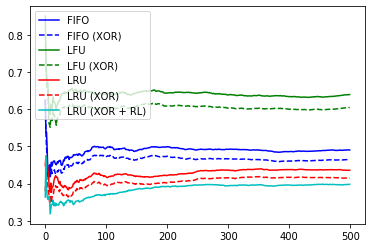

0.4900833572865766
0.46442943374532913
0.639269406392694
0.6044831880448319
0.4358332205225396
0.4145796669825369
0.39791790995292087


In [8]:
t = [n for n in range(test_N)]

plt.plot(t,FIFO_test,'b')
plt.plot(t,FIFO_Xtest,'b--')
plt.plot(t,LFU_test,'g')
plt.plot(t,LFU_Xtest,'g--')
plt.plot(t,LRU_test,'r')
plt.plot(t,LRU_Xtest,'r--')
plt.plot(t,RL_test,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

print(FIFO_test[test_N-1])
print(FIFO_Xtest[test_N-1])
print(LFU_test[test_N-1])
print(LFU_Xtest[test_N-1])
print(LRU_test[test_N-1])
print(LRU_Xtest[test_N-1])
print(RL_test[test_N-1])

# by rho

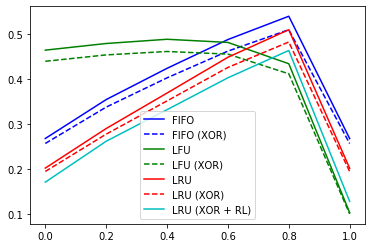

In [9]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

rho_list = [i*0.2 for i in range(6)]

for rho in rho_list:
    RL_connection, RL_test = RL_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param, 'LRU')
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(rho_list,FIFO_connection_list,'b')
plt.plot(rho_list,FIFO_Xconnection_list,'b--')
plt.plot(rho_list,LFU_connection_list,'g')
plt.plot(rho_list,LFU_Xconnection_list,'g--')
plt.plot(rho_list,LRU_connection_list,'r')
plt.plot(rho_list,LRU_Xconnection_list,'r--')
plt.plot(rho_list,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

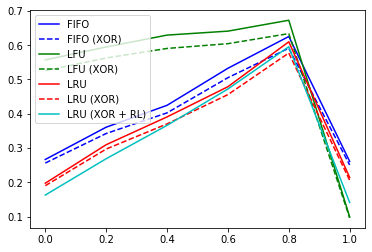

In [10]:
plt.plot(rho_list,FIFO_test_list,'b')
plt.plot(rho_list,FIFO_Xtest_list,'b--')
plt.plot(rho_list,LFU_test_list,'g')
plt.plot(rho_list,LFU_Xtest_list,'g--')
plt.plot(rho_list,LRU_test_list,'r')
plt.plot(rho_list,LRU_Xtest_list,'r--')
plt.plot(rho_list,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

# by Cache Size

In [11]:
rho = 0.5

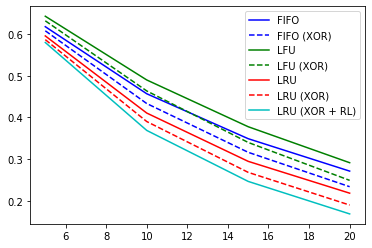

In [12]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

cache_sizes = [i*5 for i in range(1,5)]

for size in cache_sizes:
    RL_connection, RL_test = RL_Caching(M, N, num_of_video, num_of_client, size, zipf_param, 'LRU')
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num_of_client, size, zipf_param)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num_of_client, size, zipf_param)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num_of_client, size, zipf_param)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(cache_sizes,FIFO_connection_list,'b')
plt.plot(cache_sizes,FIFO_Xconnection_list,'b--')
plt.plot(cache_sizes,LFU_connection_list,'g')
plt.plot(cache_sizes,LFU_Xconnection_list,'g--')
plt.plot(cache_sizes,LRU_connection_list,'r')
plt.plot(cache_sizes,LRU_Xconnection_list,'r--')
plt.plot(cache_sizes,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

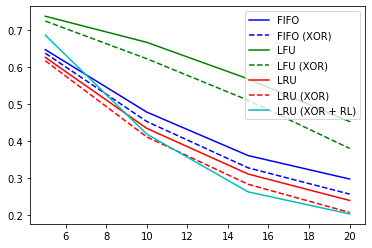

In [13]:
plt.plot(cache_sizes,FIFO_test_list,'b')
plt.plot(cache_sizes,FIFO_Xtest_list,'b--')
plt.plot(cache_sizes,LFU_test_list,'g')
plt.plot(cache_sizes,LFU_Xtest_list,'g--')
plt.plot(cache_sizes,LRU_test_list,'r')
plt.plot(cache_sizes,LRU_Xtest_list,'r--')
plt.plot(cache_sizes,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

# by Number of Clients

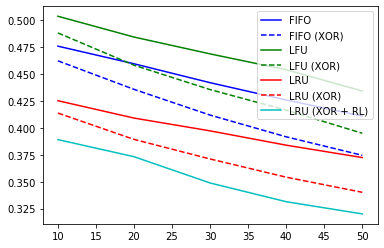

In [14]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

number_of_clients = [i*10 for i in range(1,6)]

for num in number_of_clients:
    RL_connection, RL_test = RL_Caching(M, N, num_of_video, num, cache_size, zipf_param, 'LRU')
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num, cache_size, zipf_param)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num, cache_size, zipf_param)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num, cache_size, zipf_param)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(number_of_clients,FIFO_connection_list,'b')
plt.plot(number_of_clients,FIFO_Xconnection_list,'b--')
plt.plot(number_of_clients,LFU_connection_list,'g')
plt.plot(number_of_clients,LFU_Xconnection_list,'g--')
plt.plot(number_of_clients,LRU_connection_list,'r')
plt.plot(number_of_clients,LRU_Xconnection_list,'r--')
plt.plot(number_of_clients,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

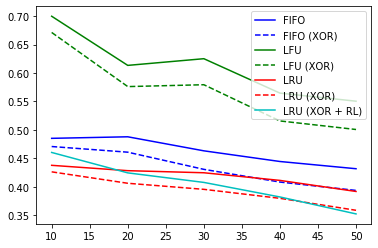

In [15]:
plt.plot(number_of_clients,FIFO_test_list,'b')
plt.plot(number_of_clients,FIFO_Xtest_list,'b--')
plt.plot(number_of_clients,LFU_test_list,'g')
plt.plot(number_of_clients,LFU_Xtest_list,'g--')
plt.plot(number_of_clients,LRU_test_list,'r')
plt.plot(number_of_clients,LRU_Xtest_list,'r--')
plt.plot(number_of_clients,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

# by Number of Videos

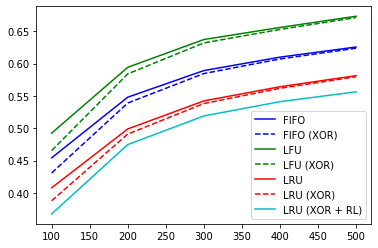

In [16]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

number_of_videos = [i*100 for i in range(1,6)]

for num in number_of_videos:
    RL_connection, RL_test = RL_Caching(M, N, num, num_of_client, cache_size, zipf_param, 'LRU')
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num, num_of_client, cache_size, zipf_param)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num, num_of_client, cache_size, zipf_param)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num, num_of_client, cache_size, zipf_param)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(number_of_videos,FIFO_connection_list,'b')
plt.plot(number_of_videos,FIFO_Xconnection_list,'b--')
plt.plot(number_of_videos,LFU_connection_list,'g')
plt.plot(number_of_videos,LFU_Xconnection_list,'g--')
plt.plot(number_of_videos,LRU_connection_list,'r')
plt.plot(number_of_videos,LRU_Xconnection_list,'r--')
plt.plot(number_of_videos,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

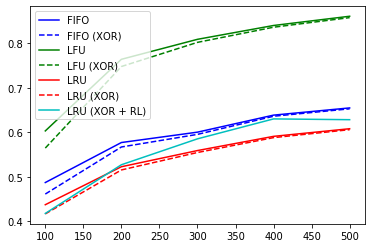

In [17]:
plt.plot(number_of_videos,FIFO_test_list,'b')
plt.plot(number_of_videos,FIFO_Xtest_list,'b--')
plt.plot(number_of_videos,LFU_test_list,'g')
plt.plot(number_of_videos,LFU_Xtest_list,'g--')
plt.plot(number_of_videos,LRU_test_list,'r')
plt.plot(number_of_videos,LRU_Xtest_list,'r--')
plt.plot(number_of_videos,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

# by zipf parameter

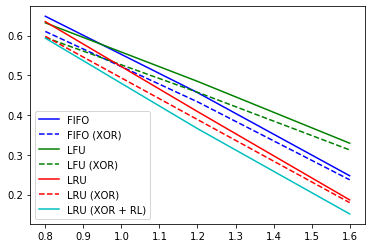

In [18]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

zipf_parameters = [i*0.4 for i in range(2, 5)]

for zipf in zipf_parameters:
    RL_connection, RL_test = RL_Caching(M, N, num_of_video, num_of_client, cache_size, zipf, 'LRU')
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num_of_client, cache_size, zipf)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(zipf_parameters,FIFO_connection_list,'b')
plt.plot(zipf_parameters,FIFO_Xconnection_list,'b--')
plt.plot(zipf_parameters,LFU_connection_list,'g')
plt.plot(zipf_parameters,LFU_Xconnection_list,'g--')
plt.plot(zipf_parameters,LRU_connection_list,'r')
plt.plot(zipf_parameters,LRU_Xconnection_list,'r--')
plt.plot(zipf_parameters,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

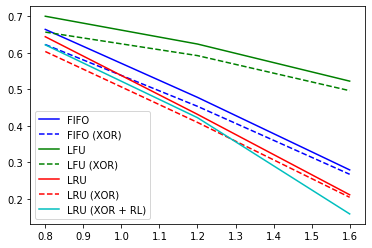

In [19]:
plt.plot(zipf_parameters,FIFO_test_list,'b')
plt.plot(zipf_parameters,FIFO_Xtest_list,'b--')
plt.plot(zipf_parameters,LFU_test_list,'g')
plt.plot(zipf_parameters,LFU_Xtest_list,'g--')
plt.plot(zipf_parameters,LRU_test_list,'r')
plt.plot(zipf_parameters,LRU_Xtest_list,'r--')
plt.plot(zipf_parameters,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()